In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from IPython.display import Image
import tqdm

# Blackjack Rules & Assumptions 🃏
* Player competes independently against the dealer, and wants the higher sum *without* exceeding 21
* Numbered cards take face value; J,Q,K count for 10; Aces are either 11 or 1
* Player and dealer are dealt two cards; one of the dealer's cards is face-up
* Player actions: **hit** (take another card) or **stick** (do not take another card)
* Assume this fixed policy for the dealer: stick on a sum of 17 or more; otherwise hit
* Book assumes cards are dealt from infinite deck
----
* Episodic finite MDP with rewards +1, -1, 0 for win, loss, draw

In [2]:
random.seed(5)
np.random.seed(5)

In [3]:
def deal():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return 11 if card == 1 else card

In [4]:
def adjust_aces(hand):
    """
    :param hand: list of card values
    Aces count for 1 instead of 11 once the sum passes 21.
    Adjust the hand accordingly.
    """
    if 11 in hand and sum(hand) > 21:
        hand.remove(11)
        hand.append(1)

In [5]:
def dealer_policy(dealer_hand):
    # fixed dealer policy
    while sum(dealer_hand) < 17:
        dealer_hand.append(deal())
        adjust_aces(dealer_hand)

In [6]:
def evaluate_winner(player_score, dealer_score):
    player_score = (player_score <= 21) * player_score
    dealer_score = (dealer_score <= 21) * dealer_score
    if dealer_score > player_score:
        return (-1, player_score, dealer_score)
    if dealer_score < player_score:
        return (1, player_score, dealer_score)
    return (0, player_score, dealer_score)

### Evaluate a fixed player policy

In [7]:
def player_policy(player_hand, dealers_first):
    while sum(player_hand) < 21:
        if sum(player_hand) % 2 == 1:
            return
        player_hand.append(deal())
        adjust_aces(player_hand)

In [8]:
def run_episode():
    # setup
    dealer_hand = [deal(), deal()]
    player_hand = [deal(), deal()]
    adjust_aces(dealer_hand)
    adjust_aces(player_hand)
    
    # player turn
    player_policy(player_hand, dealer_hand[0])
    
    # dealer turn
    dealer_policy(dealer_hand)
    
    # assign rewards
    score = evaluate_winner(sum(player_hand), sum(dealer_hand))
    reward = score[0]
    
    return pd.DataFrame({
        'player_hand': [str(player_hand)], 'dealer_hand': [str(dealer_hand)],
        'player_score': [score[1]],'dealer_score': [score[2]],
        'reward': [reward]
    })

In [9]:
runs = 1000

d = run_episode()
for _ in tqdm.tqdm(range(runs - 1)):
    result = run_episode()
    d = d.append(result, ignore_index=True)
print(f'Average Reward: {sum(d["reward"])/d.shape[0]}')
d.head()

100%|██████████| 999/999 [00:01<00:00, 949.41it/s]

Average Reward: -0.275


,player_hand,dealer_hand,player_score,dealer_score,reward
0,"[7, 10, 1, 9]","[4, 7, 5, 8]",0,0,0
1,"[11, 8]","[10, 11]",19,21,-1
2,"[6, 8, 1]","[10, 2, 10]",15,0,1
3,"[2, 5]","[10, 10]",7,20,-1
4,"[10, 10, 10]","[7, 3, 10]",0,20,-1


## Monte Carlo Exploring Starts
* State $S =$(dealer's first card $\in \{A,2,3,...,10\}$, player sum $=P \in \{12,13,...,21\}$, usable ace binary)

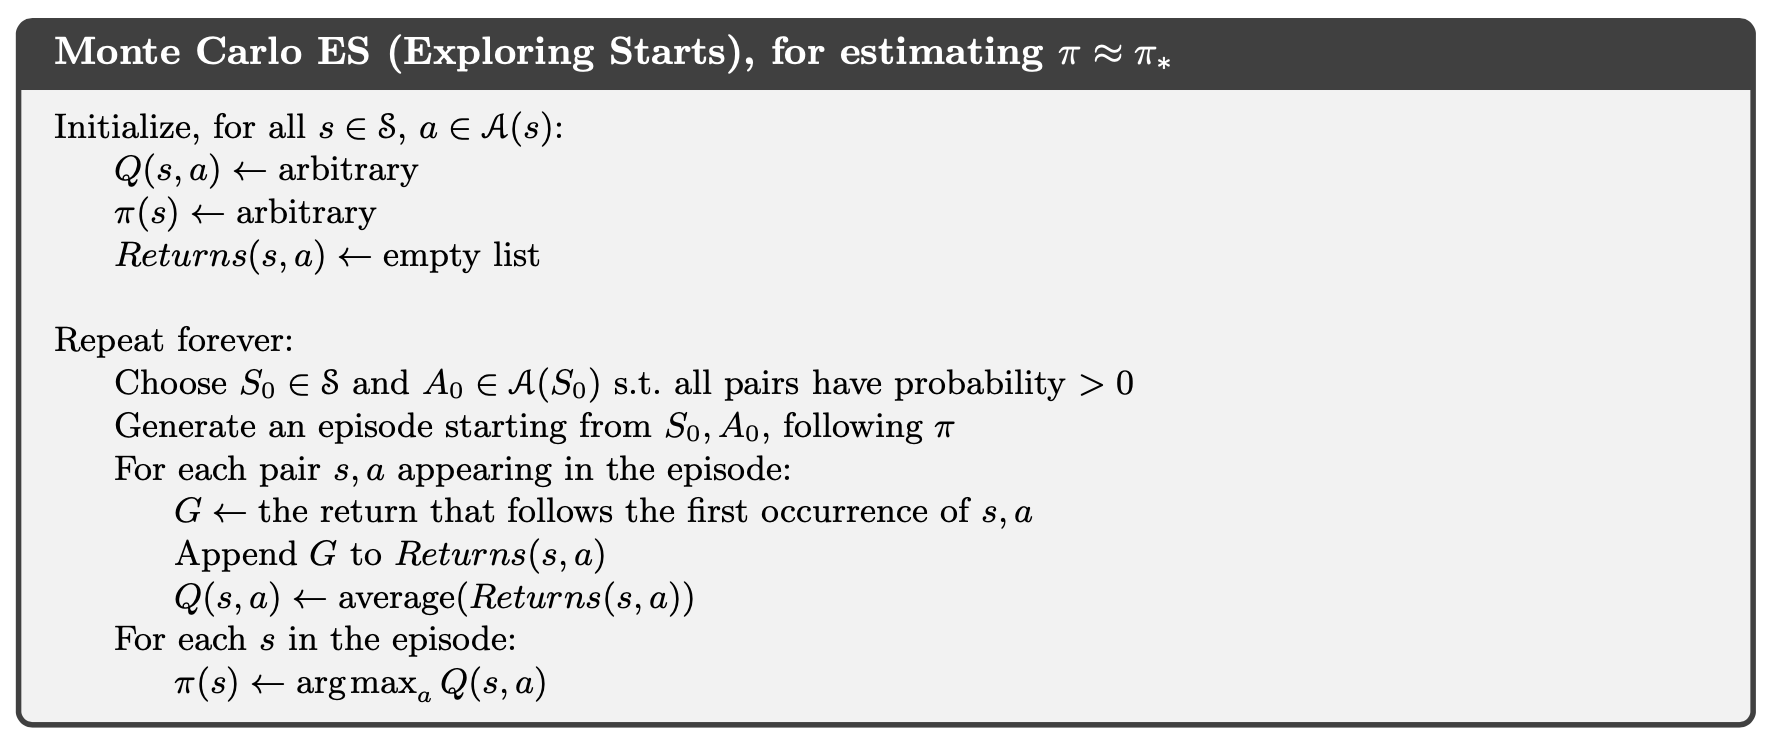

In [10]:
Image("images/MC_ES.png")

In [11]:
def episode(s, A_0, player_hand, dealer_hand):
    # player turn
    while sum(player_hand) < 12:
        player_hand.append(deal())
        adjust_aces(player_hand)
    s[1] = sum(player_hand) - 12
    sa_pairs = [(s, A_0)]
    a = 1
    while (a == 1) and (sum(player_hand) < 21):
        if A_0 is not None:
            a = A_0
            A_0 = None
        else:
            while sum(player_hand) < 12:
                player_hand.append(deal())
                adjust_aces(player_hand)
            a = pi[s[0]][s[1]][s[2]]
        if a == 1:  # if policy says hit
            player_hand.append(deal())
            adjust_aces(player_hand)
            if sum(player_hand) <= 21:
                sa_pairs.append(([s[0], sum(player_hand) - 12, int(11 in player_hand)], a))
    
    # dealer turn
    dealer_policy(dealer_hand)
    
    # assign rewards
    score = evaluate_winner(sum(player_hand), sum(dealer_hand))
    reward = score[0]
    
    return pd.DataFrame({
        'player_hand': [str(player_hand)], 'dealer_hand': [str(dealer_hand)],
        'player_score': [score[1]],'dealer_score': [score[2]],
        'reward': [reward]
    }), sa_pairs

In [12]:
def iterate(n, results):
    # setup
    usable_ace = np.random.choice(range(2))
    init_player_sum = np.random.choice(range(12, 22))
    if usable_ace == 1:
        card1 = 11
    else:
        card1 = np.random.choice(range(2, init_player_sum - 1))
    card2 = init_player_sum - card1
    player_hand = [card1, card2]
    adjust_aces(player_hand)
    
    dealer_hand = [np.random.choice(range(2, 12)), deal()]
    face_up = (dealer_hand[0] - 1) % 10  # Ace = 0
    adjust_aces(dealer_hand)
    S_0 = [face_up, sum(player_hand) - 12, usable_ace]
    A_0 = random.randint(0,1)

    result, pairs = episode(S_0, A_0, player_hand, dealer_hand)
    if n > 0:
        results = results.append(result, ignore_index=True)
    else:
        results = result
    
    # update Q
    for (s,a) in pairs:
        a = int(a)
        Q_count[s[0],s[1],s[2],a] += 1
        Q[s[0],s[1],s[2],a] += int(result['reward'])
        
        # update pi
        v = [0,0]
        if Q_count[s[0],s[1],s[2],0] > 0:
            v[0] = Q[s[0],s[1],s[2],0] / Q_count[s[0],s[1],s[2],0]
        if Q_count[s[0],s[1],s[2],1] > 0:
            v[1] = Q[s[0],s[1],s[2],1] / Q_count[s[0],s[1],s[2],1]
        pi[s[0]][s[1]][s[2]] = np.random.choice([x for x in [0,1] if v[x] == max(v)])
    return results

In [13]:
runs = 70000
results = None

Q = np.zeros((10,10,2,2))  # dealer's card, player sum, has ace?, stick (0) vs hit(1); values = Q estimates
Q_count = np.zeros((10,10,2,2))
pi = np.zeros((10,10,2))  # dealer's card, player sum, has ace?; values = action
# Initial Policy
for d in range(10):
    for p in range(10):
        for a in range(2):
            if p < 8:
                pi[d][p][a] = 1

for n in tqdm.tqdm(range(0, runs)):
    results = iterate(n, results)

# Average the rewards
Q[:,:,:,0] = Q[:,:,:,0] / Q_count[:,:,:,0]
Q[:,:,:,1] = Q[:,:,:,1] / Q_count[:,:,:,1]

100%|██████████| 70000/70000 [02:56<00:00, 397.44it/s]


In [14]:
results.head()

,player_hand,dealer_hand,player_score,dealer_score,reward
0,"[9, 12]","[3, 10, 3, 3]",21,19,1
1,"[8, 5, 5, 10]","[7, 6, 8]",0,21,-1
2,"[11, 4]","[3, 11, 1, 5]",15,20,-1
3,"[9, 10, 1]","[7, 4, 3, 6]",20,20,0
4,"[11, 9]","[4, 10, 10]",20,0,1


In [15]:
def plot_heatmap(Q):
    plt.imshow(Q, cmap='hot', extent=[12, 21, 10, 0])
    plt.xlabel("Player Sum")
    plt.ylabel("Face-up Dealer Card")
    plt.show()

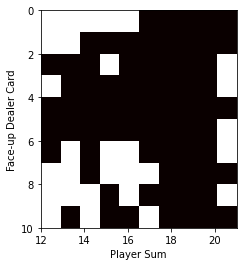

In [16]:
# Black = stick, white = hit
plot_heatmap(pi[:,:,0]) # no usable ace

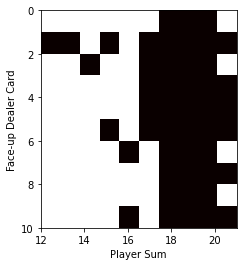

In [17]:
plot_heatmap(pi[:,:,1]) # usable ace

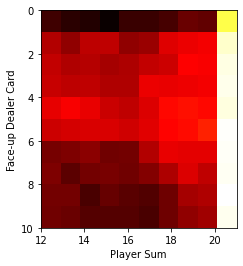

In [18]:
plot_heatmap(Q[:,:,0,1])  # no usable ace and hits

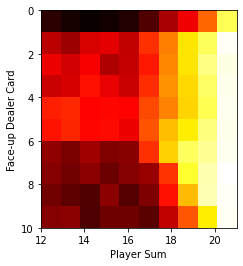

In [19]:
plot_heatmap(Q[:,:,0,0])  # no usable ace and sticks

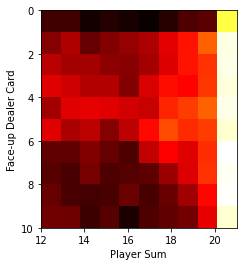

In [20]:
plot_heatmap(Q[:,:,1,1])  # usable ace and hits

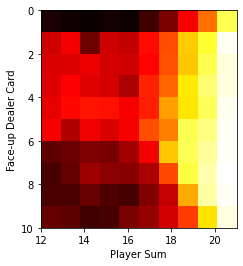

In [21]:
plot_heatmap(Q[:,:,1,0])  # usable ace and sticks

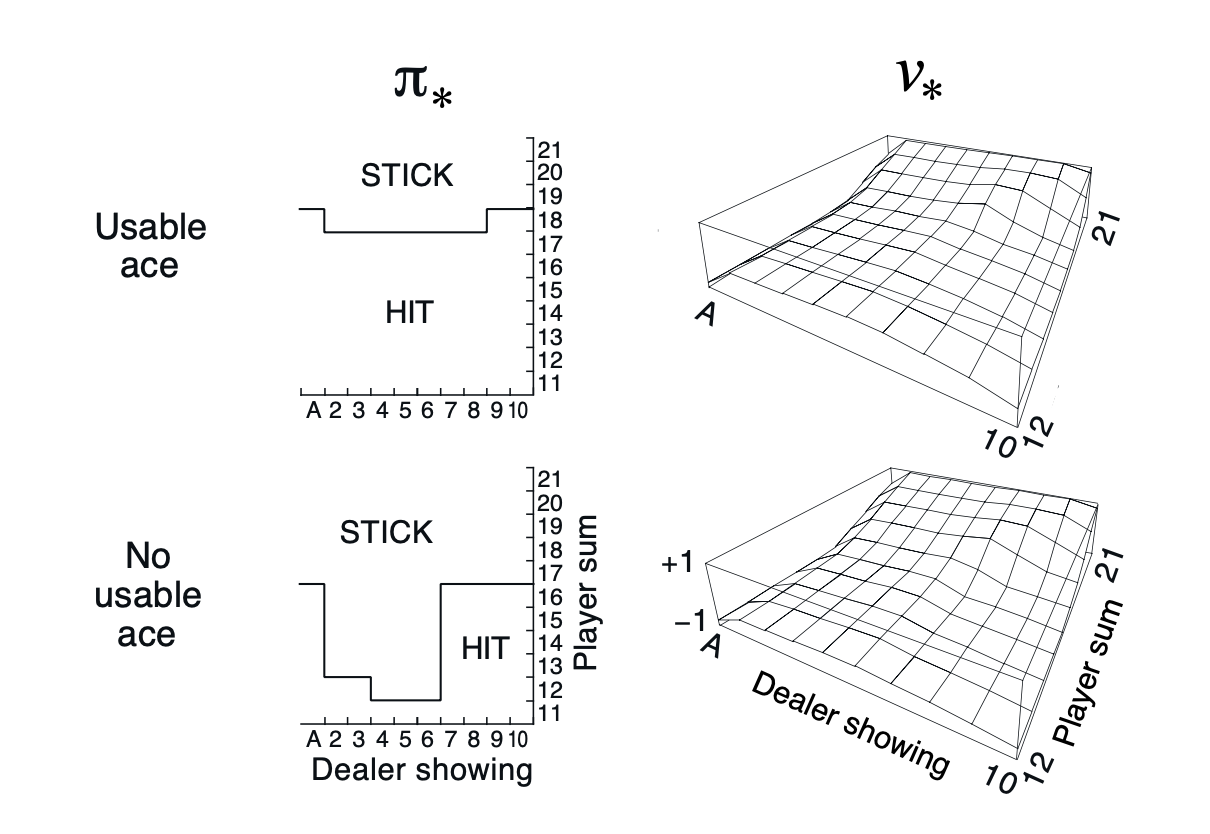

In [22]:
# Results from the book, pg 82
# produced with 500,000 iterations
Image("images/MC_ES_graphs.png")

## Off-policy (Example 5.4)
**Setup:**
* Evaluate a specific state: dealer shows a 2, player sum = 13, player has an ace (hand = A A A or A 2)
* Target policy = stick only on a sum of 20 or 21
* Value of the state under target policy $\approx$ −0.27726 (from 100 million runs)
* Behavior policy = hit or stick 50/50

**Results:**
* Value of the state was closely approximated in 1000 iterations (with both weighted and ordinary importance sampling)

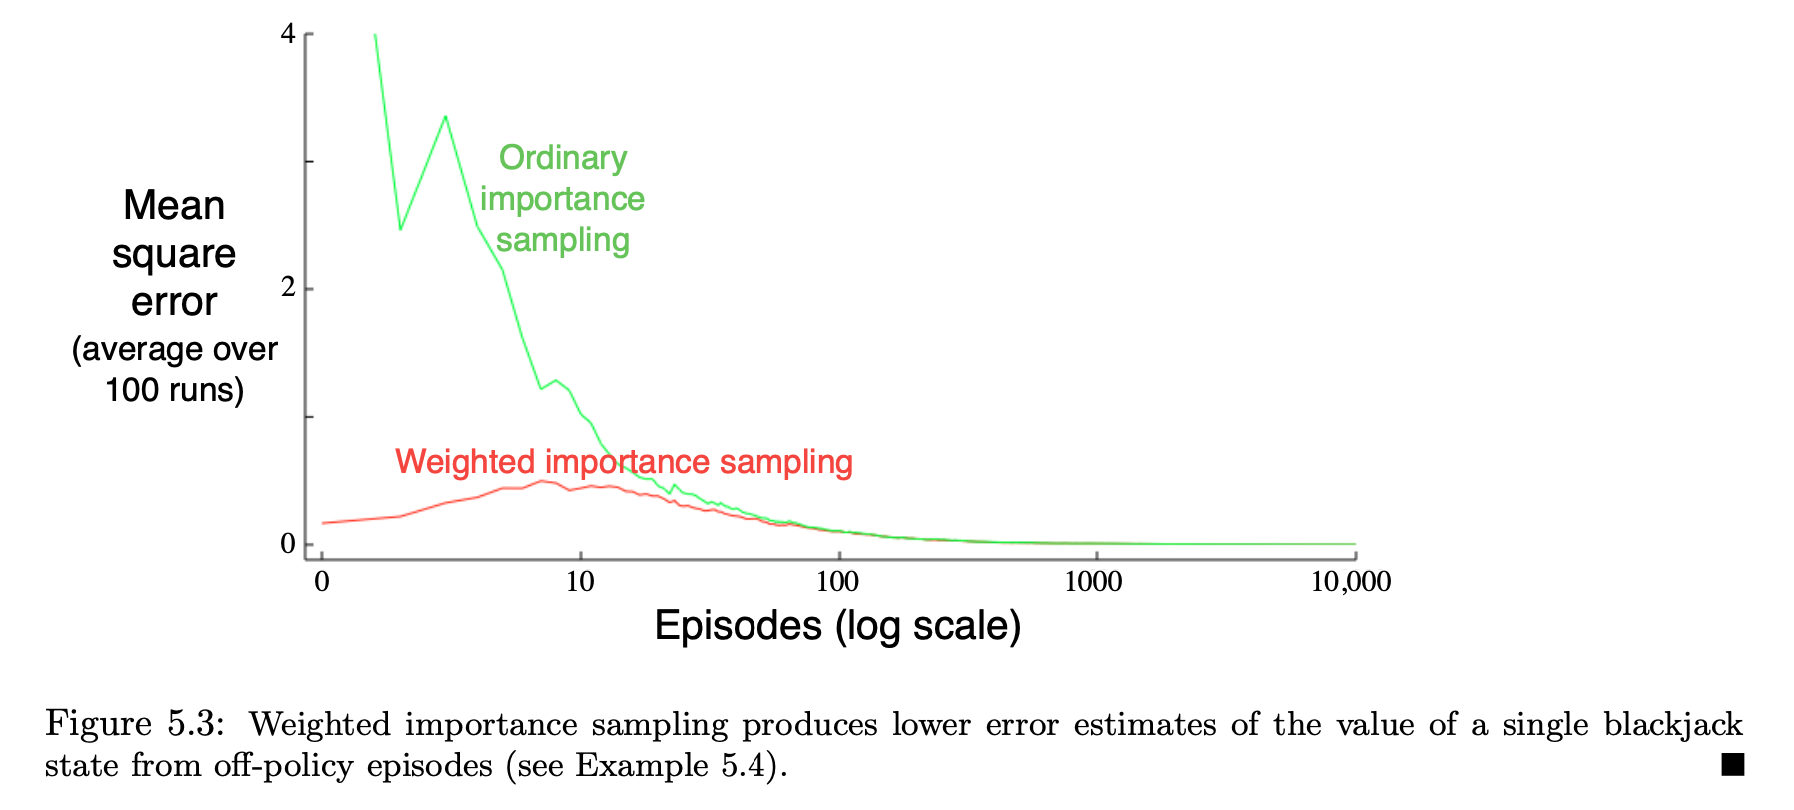

In [23]:
Image("images/MC_5_3.png")